<a href="https://colab.research.google.com/github/deepthidornala/DLAssignment-1/blob/main/DLAssignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# **CIFAR-100 Dataset**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import random

In [ ]:
#loading CIFAR-100 dataset
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
class_names = train_data.classes
print(f"Total Classes: {len(class_names)}")

Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Total Classes: 100


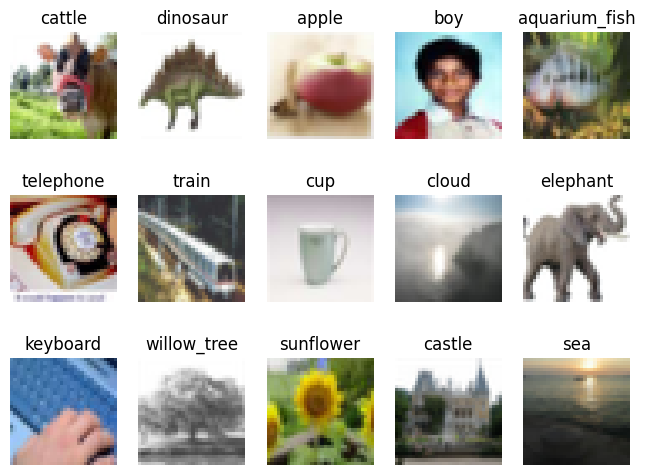

In [ ]:
# Show images
def show_sample_images():
    fig, axes = plt.subplots(3, 5, figsize=(8, 6))
    for i, ax in enumerate(axes.flat):
        img, label = train_data[i]
        img = img * 0.5 + 0.5
        img = np.transpose(img.numpy(), (1, 2, 0))
        ax.imshow(img)
        ax.set_title(class_names[label])
        ax.axis("off")
    plt.show()
show_sample_images()

In [ ]:
# Split train data into training and validation sets
BATCH_SIZE = 32
train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_subset, val_subset = random_split(train_data, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#Feedforward Neural Network
class FeedForwardNN(nn.Module):
    def __init__(self, input_size=3072, hidden_layers=[128, 64], num_classes=100, activation='relu'):
        super().__init__()
        layers = []
        prev_size = input_size
        for h in hidden_layers:
            layers.append(nn.Linear(prev_size, h))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            layers.append(nn.Dropout(0.3))
            prev_size = h
        layers.append(nn.Linear(prev_size, num_classes))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [ ]:
#defining the Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.to(DEVICE)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

In [ ]:
#definig Evaluation Functions
def evaluate(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
#definig Confusion Matrix
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Epoch 1/10, Loss: 4.0742, Val Accuracy: 13.50%
Epoch 2/10, Loss: 3.8200, Val Accuracy: 14.54%
Epoch 3/10, Loss: 3.7379, Val Accuracy: 15.34%
Epoch 4/10, Loss: 3.6942, Val Accuracy: 15.66%
Epoch 5/10, Loss: 3.6587, Val Accuracy: 16.08%
Epoch 6/10, Loss: 3.6289, Val Accuracy: 17.30%
Epoch 7/10, Loss: 3.6077, Val Accuracy: 17.20%
Epoch 8/10, Loss: 3.5820, Val Accuracy: 17.46%
Epoch 9/10, Loss: 3.5705, Val Accuracy: 17.48%
Epoch 10/10, Loss: 3.5575, Val Accuracy: 17.40%
Training Complete!
Test Accuracy: 18.61%


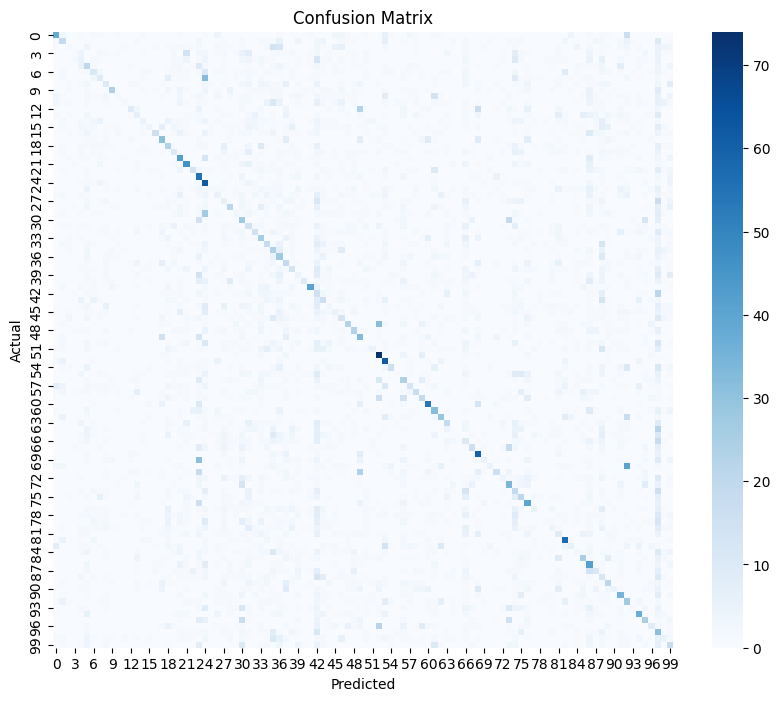

In [ ]:
HIDDEN_LAYERS = [256, 128]
LEARNING_RATE = 1e-3
EPOCHS = 10
model = FeedForwardNN(hidden_layers=HIDDEN_LAYERS, activation='relu').to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)
test_accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")
plot_confusion_matrix(model, test_loader)

## **CIFAR-10 Dataset**

In [ ]:
EVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
class_names = train_data.classes
print(f"Total Classes: {len(class_names)}")
print(f"Class Names: {class_names}")

Using device: cpu


100%|██████████| 170M/170M [00:05<00:00, 29.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Total Classes: 10
Class Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


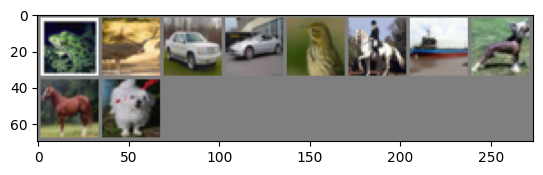

['frog', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'dog', 'horse', 'dog']


In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))
print([class_names[labels[i]] for i in range(10)])

In [ ]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_units, output_size, activation='ReLU'):
        super(FeedforwardNN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_units[0]))
        layers.append(nn.ReLU() if activation == 'ReLU' else nn.Sigmoid())
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_units[i], hidden_units[i+1]))
        layers.append(nn.Linear(hidden_units[-1], output_size))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

In [ ]:
net = FeedforwardNN(input_size=32*32*3, hidden_layers=[64, 64, 64], hidden_units=[64, 64, 64], output_size=10).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
def train_model(net, trainloader, optimizer, num_epochs=10):
    net.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')
    print("Training Finished")
train_model(net, trainloader, optimizer_adam, num_epochs=5)

Epoch 1, Loss: 1.177587209072772
Epoch 2, Loss: 1.1578998787236838
Epoch 3, Loss: 1.1451636945217447
Epoch 4, Loss: 1.1290647576271686
Epoch 5, Loss: 1.1163487286042955
Training Finished


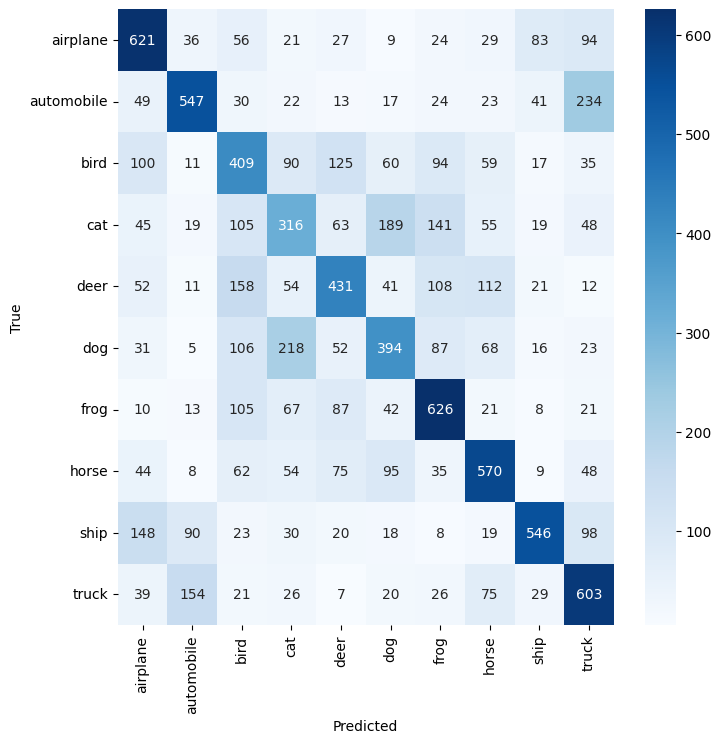

In [ ]:
def plot_confusion_matrix(net, testloader):
    all_preds = []
    all_labels = []
    net.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            inputs = inputs.view(inputs.size(0), -1)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
plot_confusion_matrix(net, testloader)